# ETL - Pipeline de Booking con Apache Spark
* **Curso:** Master de Big Data & Business Intelligence
* **Asignatura:** Procesamiento de Datos Masivos
* **Alumno:** Raul Alvaro Proleon

## 1. Importing Libraries

In [1]:
!apt-get update

# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz

# unzip the spark file to the current folder
!tar xf spark-3.5.4-bin-hadoop3.tgz

# install findspark using pip
!pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,722 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,351 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [2]:
# Importamos Librerias

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark.sql import SparkSession   # crear la session de spark
from pyspark.sql import SQLContext     # utilizar las funciones de spark

spark = SparkSession.builder.appName("Test_spark").master("local[*]").getOrCreate()
sqlCtx = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
spark

from pyspark.sql.window import Window  # manipulacion de ventana
from pyspark.sql import functions as F # operaciones para un dataframe
from pyspark.sql.types import IntegerType # convertir datos
from pyspark.sql.types import DateType    # convertir datos
from pyspark.sql.functions import to_date # convertir datos
import matplotlib.pyplot as plt           # Mostrar graficos
import os                                 # Funciones del Sistema Operativo

from google.colab import drive  # conectarse a google drive
drive.mount('/content/drive')   # conectarse a google drive

!unzip Proyecto_Booking_Raul_AlvaroProleon.zip

Mounted at /content/drive
Archive:  Proyecto_Booking_Raul_AlvaroProleon.zip
  inflating: Proyecto_Booking_Raul_AlvaroProleon/README.md  
  inflating: Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_tarifa_diaria.csv/_SUCCESS  
  inflating: Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_tarifa_diaria.csv/._SUCCESS.crc  
  inflating: Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_tarifa_diaria.csv/.part-00000-2d4f748e-f56d-4fee-8253-4606e07a539d-c000.csv.crc  
  inflating: Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_tarifa_diaria.csv/part-00000-2d4f748e-f56d-4fee-8253-4606e07a539d-c000.csv  
  inflating: Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_dias_espera.csv/._SUCCESS.crc  
  inflating: Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_dias_espera.csv/_SUCCESS  
  inflating: Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_reservas_cancelacion.csv/_SUCCESS  
  inflating: Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_reservas_cancelaci

## 2.Functions ETL

In [3]:
#################################
# Función de la Capa Extracción #
#################################
def f_extraccion(path):
  # Ruta archivo Input
  file_path = path
  # Creamos el DataFrame Spark
  df_hotel = spark.read.csv(file_path, header=True, inferSchema=True)
  # Dimenciones del Dataset
  print('Columnas:',len(df_hotel.columns))
  print('Registros:',df_hotel.count())
  # Muestra las primeras 5 filas del DataFrame
  #df_hotel.show( 5 , False )
  return df_hotel

# Función para hallar Missings
def f_analisis_missings(df):
  registros=df.count()
  # Dataframe con cantidad de valores missing
  df_nan=df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns])
  # Columnas solo con valores missing
  df_col_nan = [c for c in df_nan.columns if df_nan.select(F.col(c)).first()[0] > 0]
  # Porcentaje de Valores Missing
  df_missings=df_nan.select( [(F.col(c)/F.lit(registros)).alias(c) for c in df_col_nan ])
  return df_missings

# Función de la Capa de EDA (Analsis Exploratorio)
def f_eda(df):
  # Medidas de tendencia Central
  print("  2.1.Medidas de tendencia Central:")
  df.describe().show()
  # Estructura del DataFrame
  print("  2.2.Estructura del DataFrame:")
  df.printSchema()
  # Analisis de missings
  print("  2.3.Analisis de missings:")
  df_missings=f_analisis_missings(df)
  df_missings.show()
  # Analisis de Duplicados
  print("  2.4.Analisis de Duplicados:")
  registros_distintos=df.distinct().count()
  registros_totales=df.count()
  registro_clave=df.select(F.col('index')).distinct().count()
  print("   -Cantidad de registros Totales: "+str(registros_totales))
  print("   -Cantidad de registros por campo index: "+str(registro_clave))
  print("   -Cantidad de registros distintos: "+str(registros_distintos))
  # Analisis de Outliers
  print("  2.5.Analisis de Outliers con Boxplot:")
  numerical_cols = [col for col, dtype in df.dtypes if dtype in ['int', 'double']]
  plot_numeros_boxplots(df, numerical_cols)


# Función para graficar diagrama de cajas
def plot_numeros_boxplots(df_spark, cols_to_plot, rows=6, cols=4):
    df=df_spark.toPandas()      # convertir a pandas para graficar
    num_plots = len(cols_to_plot)  # columnas para el boxplot
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  # Ajustar a necesidad
    # Graficamos para cada columna
    for i, col in enumerate(cols_to_plot):
        if col in df.columns:
            row = i // cols
            col_idx = i % cols
            # Borrar potencial nan:
            data_to_plot = df[col].dropna()
            axes[row, col_idx].boxplot(data_to_plot, vert=True)
            axes[row, col_idx].set_title(f'Boxplot of {col}')
            axes[row, col_idx].set_xlabel(col)
    # No mostrar los subplots vacios:
    for i in range(num_plots, rows * cols):
        row = i // cols
        col_idx = i % cols
        axes[row, col_idx].axis('off')

    plt.tight_layout()  # Adjustar el diseño
    plt.show() # Mostrar

# Función para modificar los tipos de Datos
def f_casting_df(df,num_cols,fecha_cols):
  # Cast para cambiar a Entero
  for column in num_cols:
    df = df.withColumn(column,F.col(column).cast(IntegerType()))
  # Cast para cambiar cadena a fecha
  for column in fecha_cols:
    df_fecha = df.withColumn(column, to_date(df[column], 'dd-MM-yy')) # Formato de entrada dd-mm-yy
    df_cast_fecha = df_fecha.withColumn(column, F.date_format(column, "dd/MM/yyyy")) # Formato de salida dd/mm/yyyy

  return df_cast_fecha

#######################################
# Función de la Capa Transformación   #
#######################################
def f_transformacion(df):
  print("  3.1.Fase de Limpieza de Datos:")
  # Casting de datos
  num_cols=['children','agent','company']
  fecha_cols=['reservation_status_date']
  df_cast=f_casting_df(df,num_cols,fecha_cols)
  print("   -Modificando los tipos de Datos Float a Int: "+str(num_cols))
  print("   -Modificando los tipos de Datos String a Date: "+str(fecha_cols))
  # tratamiento de missing
  mi_dict = {'country': 'No Ubicado', 'children': 0}
  df_tranf_sin_nan=f_tratar_missing(df_cast,mi_dict)
  print("  3.2.Tratamiento de missing: "+str(mi_dict) )
  df_sin_nan=f_analisis_missings(df_tranf_sin_nan)
  df_sin_nan.show(3)
  # Creacion de nuevas columnas
  print("  3.3.Fase de Feature Engineerings:")
  df_huspedes=df_tranf_sin_nan.withColumn('total_huespedes',F.col('adults')+F.col('children')+F.col('babies'))
  print("   -Creacion de nuevas columna(s): "+str(['total_huespedes']) )
  # Convertimos el mes a Español
  df_tranf_mes=df_huspedes.withColumn('arrival_date_month_esp',F.udf(f_convertir_mes)(F.col('arrival_date_month'))
                                    )
  print("   -Creacion del Mes en Español: "+str(['arrival_date_month_esp'] ))
  # Convertimos el mes a numerico
  df_tranf_mes_num=df_tranf_mes.withColumn('arrival_date_month_num',F.udf(f_convertir_mes_num)(F.col('arrival_date_month'))
                                    ).drop('arrival_date_month')
  print("   -Creacion del Mes Numerico: "+str(['arrival_date_month_num'] ))
  return df_tranf_mes_num

# Funcion para convertir el mes a español
def f_convertir_mes(mes):
  s_mes=0
  if mes == 'January': s_mes='Enero'
  elif mes == 'February': s_mes='Febrero'
  elif mes == 'March': s_mes='Marzo'
  elif mes == 'April': s_mes='Abril'
  elif mes == 'May': s_mes='Mayo'
  elif mes == 'June': s_mes='Junio'
  elif mes == 'July': s_mes='Julio'
  elif mes == 'August': s_mes='Agosto'
  elif mes == 'September': s_mes='Septiembre'
  elif mes == 'October': s_mes='Octubre'
  elif mes == 'November': s_mes='Noviembre'
  elif mes == 'December': s_mes='Diciembre'
  return s_mes

# Función para imputar los missing
def f_tratar_missing(df,vdict):
  for columna, valor in vdict.items():
    df=df.withColumn(columna, F.when(F.col(columna).isNull(), F.lit(valor)).otherwise(F.col(columna)))
  return df

# Funcion para convertir el mes a español
def f_convertir_mes_num(mes):
  n_mes=0
  if mes == 'January': n_mes=1
  elif mes == 'February': n_mes=2
  elif mes == 'March': n_mes=3
  elif mes == 'April': n_mes=4
  elif mes == 'May': n_mes=5
  elif mes == 'June': n_mes=6
  elif mes == 'July': n_mes=7
  elif mes == 'August': n_mes=8
  elif mes == 'September': n_mes=9
  elif mes == 'October': n_mes=10
  elif mes == 'November': n_mes=11
  elif mes == 'December': n_mes=12
  return n_mes

#################################
# Función de la Capa Carga      #
#################################
def f_carga(df,file_path_output1,file_path_output2,file_path_output3):
  # Carga de la Tabla 1
  df_hotel_reservas_pre=df.groupBy(F.col("arrival_date_year").alias('año'), F.col("arrival_date_month_esp").alias('mes'),
                               F.col("arrival_date_month_num").alias('mes_num')).agg(
      F.count('index').alias('reservas'),
      F.sum('is_canceled').alias('cancelaciones'),
       F.round(F.sum('is_canceled')/F.count('index')*100,2).alias('porcentaje_cancelaciones')
       ).orderBy(F.col('año'),F.col('mes_num').desc() )
  df_hotel_reservas=df_hotel_reservas_pre.drop(F.col('mes_num'))
  df_hotel_reservas.write.mode("overwrite").option('header', 'true').csv(file_path_output1)
  print("  4.1.Carga la Tabla1:Reservas y cancelaciones, porcentaje cancelados por mes y año")
  df_hotel_reservas.show(2)
  # Carga de la Tabla 2
  df_hotel_dia_espera=df.groupBy(F.col("reserved_room_type").alias('tipo_habitacion')).agg(
                      F.round(F.avg('days_in_waiting_list'),2).alias('promedio_dias_espera'),
                      F.round(F.avg('total_huespedes'),2).alias('total_huespedes'),
                      F.min('total_huespedes').alias('minimo_huespedes'),
                      F.max('total_huespedes').alias('maximo_huespedes')
                      ).orderBy(F.col('promedio_dias_espera').desc())
  df_hotel_dia_espera.write.mode("overwrite").option('header', 'true').csv(file_path_output2)
  print("  4.2.Carga la Tabla2:Promedio de días de espera y huespedes por tipo de habitación")
  df_hotel_dia_espera.show(2)
  # Carga de la Tabla 3
  df_hotel_tarifa_tranf=df.where( (F.col('is_canceled')==0) & (F.col('adr')>=0) )
  df_hotel_tarifa=df_hotel_tarifa_tranf.groupBy(F.col("reserved_room_type").alias('tipo_habitacion'),F.col("arrival_date_year").alias('año')).agg(
                  F.round(F.avg('adr'),2).alias('promedio_tarifa_diaria')
                  ).orderBy(F.col('año').asc(),F.col('promedio_tarifa_diaria').desc())
  print("  4.3.Carga la Tabla3:Promedio de tarifas diarias por tipo de habitación y año, excluyendo reservas canceladas")
  df_hotel_tarifa.write.mode("overwrite").option('header', 'true').csv(file_path_output3)
  df_hotel_tarifa.show(2)
  return print("  Tablas Cargadas en Carpeta Output")



## 3.Main ETL

--------------------------------------------
Inicio: Proceso ETL Iniciado...
--------------------------------------------
1.Extracción...
Columnas: 33
Registros: 119390
2.Analisis Exploratorio de Datos...
  2.1.Medidas de tendencia Central:
+-------+-----------------+------------+-------------------+------------------+------------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+-------------------+--------------------+---------+-------+--------------+--------------------+-------------------+----------------------+------------------------------+------------------+------------------+-------------------+------------+------------------+------------------+--------------------+---------------+------------------+---------------------------+-------------------------+------------------+-----------------------+
|summary|            index|       hotel|        is_canceled|         lead_time| arrival_date_ye

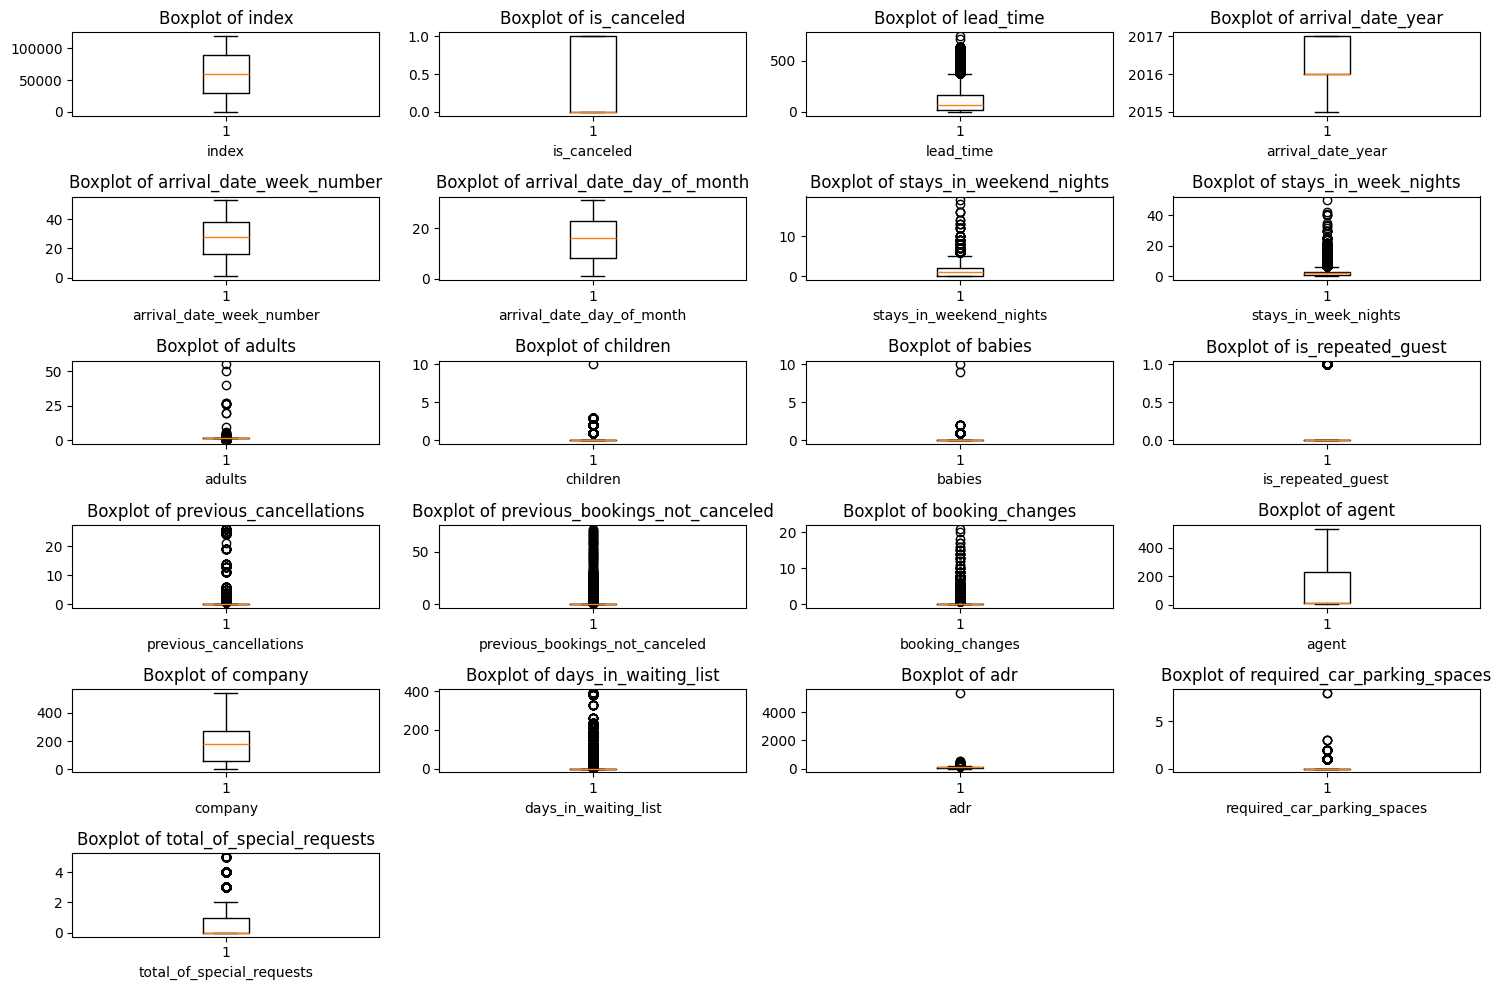

3.Transformación...
  3.1.Fase de Limpieza de Datos:
   -Modificando los tipos de Datos Float a Int: ['children', 'agent', 'company']
   -Modificando los tipos de Datos String a Date: ['reservation_status_date']
  3.2.Tratamiento de missing: {'country': 'No Ubicado', 'children': 0}
+-------------------+-----------------+
|              agent|          company|
+-------------------+-----------------+
|0.13686238378423654|0.943068933746545|
+-------------------+-----------------+

  3.3.Fase de Feature Engineerings:
   -Creacion de nuevas columna(s): ['total_huespedes']
   -Creacion del Mes en Español: ['arrival_date_month_esp']
   -Creacion del Mes Numerico: ['arrival_date_month_num']
   Resultado de las transformaciones:
+-----+------------+-----------+---------+-----------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+

In [4]:
def main():
  # Declaramos la Ruta de la carpeta actual donde esta el Archivo
  ruta_path ='/content/drive/MyDrive/Colab Notebooks'
  #ruta_path = os.getcwd()
  file_name='Proyecto_Booking_Raul_AlvaroProleon/input/hotel_bookings.csv'
  file_path=os.path.join(ruta_path,file_name)

  print("--------------------------------------------")
  print("Inicio: Proceso ETL Iniciado...")
  print("--------------------------------------------")
  print("1.Extracción...")
  df_hotel=f_extraccion(file_path)
  print("2.Analisis Exploratorio de Datos...")
  f_eda(df_hotel)
  print("3.Transformación...")
  df_processed=f_transformacion(df_hotel)
  print("   Resultado de las transformaciones:")
  df_processed.show(2)
  print("4.Carga de Datos...")
  file_name_out1 = 'Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_reservas_cancelacion.csv'
  file_name_out2 = 'Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_dias_espera.csv'
  file_name_out3 = 'Proyecto_Booking_Raul_AlvaroProleon/output/tabla_bkg_tarifa_diaria.csv'
  file_path_output1=os.path.join(ruta_path,file_name_out1)
  file_path_output2=os.path.join(ruta_path,file_name_out2)
  file_path_output3=os.path.join(ruta_path,file_name_out3)
  f_carga(df_processed,file_path_output1,file_path_output2,file_path_output3)
  print("--------------------------------------------")
  print("Fin: Proceso ETL Terminado...")
  print("--------------------------------------------")

main()

## Fin